# Predicting Neuroinflammatory Biomarkers with Metagenomics Data

In [69]:
# imports
import pandas as pd
from biom import load_table
from biom.table import Table
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import optim
import torch
import torch.nn as nn
from biom import load_table
from filtering_significance import filter_significance
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
#import feature table and metadata
ft = load_table('/home/lakhatib/Wisconsin_MARS/metagenomics/data/feature_tables/prev_zebra_collapsed_l7_ft.biom').to_dataframe().transpose()
md = pd.read_csv('/home/lakhatib/Wisconsin_MARS/metagenomics/data/metadata/MARS_MASTER_DISTINCT_SAMPLES_withBiomarkers_Nov2022.csv', index_col = 'ucsd_id')
output_path = '/home/lakhatib/BIRDMAn_output_scripts/figures'

## Assign and scale (if necessary) metadata columns

In [71]:
#extract the biomarker columns from the metadata and create a new dataframe
regression_columns = ['a_synuclein', 'a_beta_1_40', 'a_beta_1_42', 'gfap', 'il_6', 'neurogranin', 'nfl', 'p_tau', 's100', 's_trem2', 't_tau',
                     'ykl40']

cols = md[regression_columns]

#drop any rows or columns that have NaN values for all values
cols = cols.dropna(how='all')

In [72]:
#filter metag table to only include matching biomarker data and vice versa
ft = ft.loc[ft.index.intersection(cols.index)]
cols = cols.loc[cols.index.intersection(ft.index)]

In [73]:
#if necessary, scale columns

# Extract the sample IDs 
sample_ids = cols.index

# Extract the feature columns
feature_columns = cols.columns

# Apply Standard scaling
StandardScaler = StandardScaler()
cols = pd.DataFrame(StandardScaler.fit_transform(cols), columns=feature_columns, index=sample_ids)

In [74]:
cols = cols.rename(columns={'a_beta_1_40': 'Aβ40', 'a_beta_1_42': 'Aβ42', 'a_synuclein': 'α-synuclein', 'gfap': 'GFAP',
                                            'il_6': 'IL-6', 'nfl': 'NfL', 'p_tau': 'pTau', 's100': 'S100B', 's_trem2': 'sTREM2', 
                                            't_tau': 'tTau', 'ykl40':'YKL-40'})

## CLR Transform Feature Table

In [75]:
from skbio.stats.composition import clr, multiplicative_replacement

metagenomic_counts = np.array(ft)  

# Replace zeros using multiplicative replacement
metagenomic_counts = multiplicative_replacement(metagenomic_counts)

# Apply CLR transformation
clr_transformed_data = clr(metagenomic_counts)

In [76]:
ft = pd.DataFrame(clr_transformed_data,index=ft.index, columns=ft.columns)

## Loading and filtering BIRDMAn results

In [77]:
#import BIRDMan results to filter to important features
birdman = pd.read_csv('/home/lakhatib/Wisconsin_MARS/metagenomics/birdman/diagnosis/species/inferences-results/diagnosis_birdman_l7_ft.beta_var.tsv', sep = '\t')

In [78]:
top_birdman, top_positive, top_negative = filter_significance(birdman, reverse_values=True, top_40=True)

Test column: diagnosis[T.Normal]
Total features before filtering: 651
Significant features: 252
Top Features: 20
Bottom Features: 20


In [82]:
#keep the lowest label
def extract_levels(split_features):
    features = []
    for feature in split_features:
        for level in reversed(feature):
            if level not in {'s__', 'g__', 'f__', 'o__', 'c__', 'p__'}:
                features.append(level)
                break
        else:
            features.append('N/A')  # If all levels are 's__', 'g__', etc.
    return features

split_features = ft.columns.str.split(';')
ft.columns = extract_levels(split_features)

In [90]:
ft_sig = ft[top_birdman['Feature']]

In [93]:
df = pd.merge(ft_sig, cols, right_index=True, left_index=True)

## Linear Regression

In [99]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

p_results = []  # to store results
for feature in ft_sig.columns:
    for col in cols.columns:
        df_test = df.copy()

        # Convert the relevant columns to dense format if they are sparse
        if pd.api.types.is_sparse(df_test[feature]):
            df_test[feature] = df_test[feature].sparse.to_dense()
        
        # Replace infinities and drop NaN values in relevant columns
        df_test[feature] = df_test[feature].replace([np.inf, -np.inf], np.nan)
        df_test.dropna(subset=[feature, col], inplace=True)
        
        # Calculate linear regression
        if len(df_test[col]) > 1 and len(df_test[feature]) > 1:  # ensure there's enough data to compute correlation
            X = df_test[[feature]]  # Predictor
            X = sm.add_constant(X)  # Adds a constant term to the predictor
            Y = df_test[col]  # Response

            model = sm.OLS(Y, X).fit()  # Fit the regression model

            # Retrieve the regression coefficient (slope) for the predictor and its p-value
            slope = model.params[feature]
            p_value = model.pvalues[feature]

            p_results.append({
                'Feature': feature,
                'col': col,
                'slope': slope,
                'p_value': p_value
            })
        else:
            print(f"Not enough data to compute regression between {biomarker} and {species}")


# Convert results list to DataFrame
p_results_df = pd.DataFrame(p_results)

In [100]:
# Pivot table for the heatmap
heatmap_data = p_results_df.pivot("Feature", "col", "slope")

/tmp/ipykernel_390972/390551516.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = p_results_df.pivot("Feature", "col", "slope")


In [104]:
heatmap_data = heatmap_data.reset_index()

# Merge the association information into the results_df
heatmap_data = pd.merge(heatmap_data, top_birdman[['Feature', 'Group']], on='Feature', how='left')
heatmap_data = heatmap_data.set_index('Feature')

# Series for the group labels
group_labels = heatmap_data['Group']
group_labels_df = pd.DataFrame(group_labels)

In [106]:
heatmap_data = heatmap_data.sort_values('Group', ascending=False)

In [119]:
bonferroni_correct = False

In [120]:
if bonferroni_correct:

    # Calculate the number of comparisons
    num_features = len(ft_sig.columns)
    num_cols = len(cols.columns)
    total_comparisons = num_features * num_cols


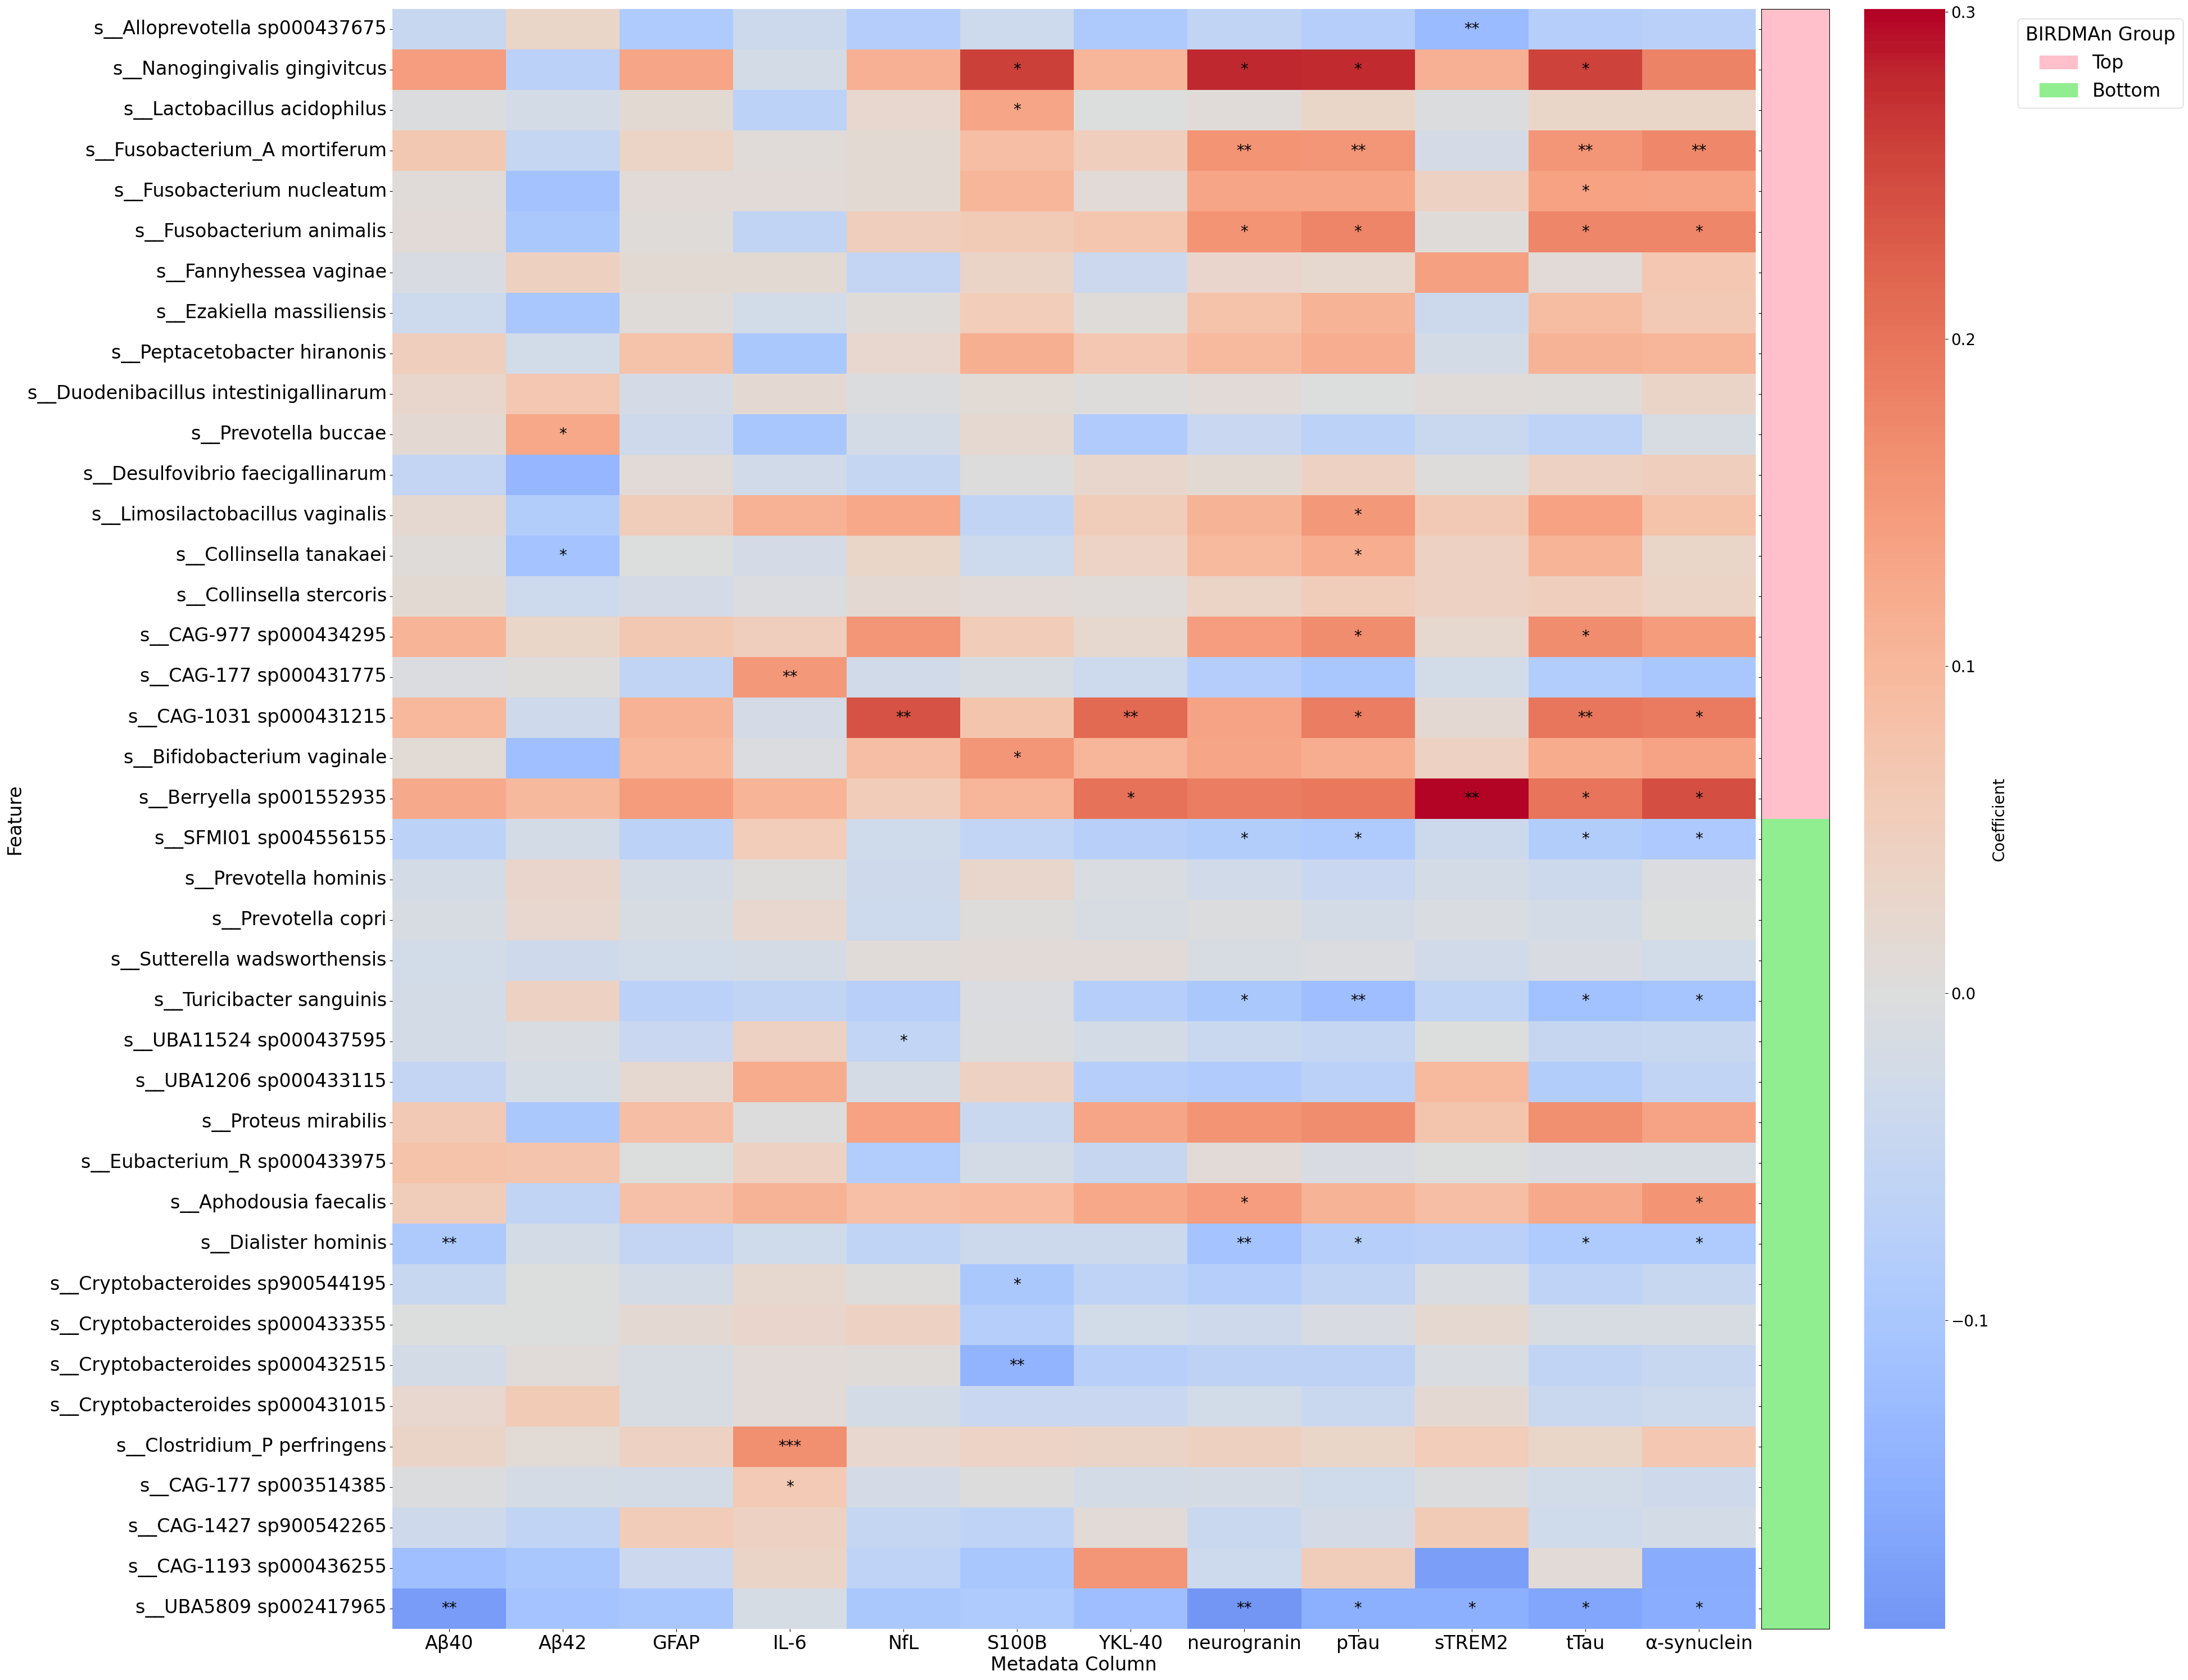

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create the figure and the main axis for the heatmap
fig, ax = plt.subplots(figsize=(39, 30))

# Map the 'Group' to numeric values: 1 for 'Top', 0 for 'Bottom'
group_numeric = group_labels_df['Group'].map({'Top': 1, 'Bottom': 0})

# Now add the numeric group as an extra column to heatmap_data
heatmap_data['BIRDMAn Group'] = group_numeric.reindex(heatmap_data.index)

# Create the heatmap and store the colorbar returned by seaborn
heatmap = sns.heatmap(heatmap_data.iloc[:, :-2], ax=ax, annot=False, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Coefficient', 'pad': 0.02}, center=0)
cbar = heatmap.collections[0].colorbar

# Set the font size for the coefficient color bar labels
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('Coefficient', size=20)

# Significance markers
for i, feature in enumerate(heatmap_data.index):
    for j, col in enumerate(heatmap_data.columns):
        if col not in ['Group','BIRDMAn Group']:
            # Ensure p_results_df is defined and contains p-values for the comparison of each species-biomarker pair
            p_value = p_results_df.loc[(p_results_df['Feature'] == feature) & (p_results_df['col'] == col), 'p_value'].values[-1]
            
            thresh_1 = .05
            thresh_2 = .01
            thresh_3 = .001
            
            if bonferroni_correct:
                thresh_1 = thresh_1/total_comparisons
                thresh_2 = thresh_2/total_comparisons
                thresh_3 = thresh_3/total_comparisons
                
            if p_value < thresh_1:
                if p_value <thresh_3:
                    ax.text(j+0.5, i+0.5, '***', ha='center', va='center', color='black', size=20)
                elif p_value < thresh_2:
                    ax.text(j+0.5, i+0.5, '**', ha='center', va='center', color='black', size=20)
                elif p_value < thresh_1:
                    ax.text(j+0.5, i+0.5, '*', ha='center', va='center', color='black', size=20)
            
# Add the categorical color bar to the right of the heatmap
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.imshow(heatmap_data[['BIRDMAn Group']].values, aspect='auto', cmap=ListedColormap(['lightgreen', 'pink']))
cax.set_yticks(np.arange(heatmap_data.shape[0]))
cax.set_yticklabels(heatmap_data.index)
cax.yaxis.set_ticks_position('left')
cax.set_xticks([])
cax.set_xticklabels([])
cax.set_yticklabels([])

# Update the legend to include the new groupings
legend_patches = [mpatches.Patch(color='pink', label='Top'),
                  mpatches.Patch(color='lightgreen', label='Bottom')]
# Place the legend to the right of the group bar, adjusting the bbox_to_anchor as needed
ax.legend(handles=legend_patches, bbox_to_anchor=(1.32, 1), fontsize=24, title="BIRDMAn Group", title_fontsize=24)
# Increase the font size of y-axis tick labels
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)

# Set labels and title
ax.set_xlabel('Metadata Column', size = 24)
ax.set_ylabel('Feature',  size = 24)

plt.tight_layout()
plt.savefig(f'{output_path}/feature_metadata_regression_heatmap.png', dpi = 300, bbox_inches='tight', pad_inches=0.1)
plt.show()
